In [1]:
from huggingface_hub import hf_hub_download
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "Elriggs/pythia-70m-deduped"

# The layer around which we want to interpret by looking at the last layer
layer_focus = 1
assert layer_focus > 0

In [2]:
def load_autoencoder(layer: int):
	# No clue what this means
	# seedMaybe = 63
	seedMaybe = 31
	ae_download_location_main = hf_hub_download(repo_id=model_id, filename=f"tied_residual_l{layer_focus}_r6/_{seedMaybe}/learned_dicts.pt")
	all_autoencoders = torch.load(ae_download_location_main)
	all_l1s = [hyperparams["l1_alpha"] for autoencoder, hyperparams in all_autoencoders]
	# TODO: choose best one???
	print(all_l1s)
	auto_num = 5
	autoencoder, hyperparams = all_autoencoders[auto_num]
	# You want a hyperparam around 1e-3. Higher is less features/datapoint (at the cost of reconstruction error); lower is more features/datapoint (at the cost of polysemanticity)
	autoencoder.to_device(device)
	print(hyperparams)
	return autoencoder, hyperparams

autoencoder_main, hyperparams_main = load_autoencoder(layer_focus)
autoencoder_prior, hyperparams_prior = load_autoencoder(layer_focus - 1)

[0.0, 9.999999747378752e-05, 0.00019306977628730237, 0.000372759357560426, 0.0007196856895461679, 0.0013894954463467002, 0.0026826958637684584, 0.005179474595934153, 0.009999999776482582]
{'dict_size': 3072, 'l1_alpha': 0.0013894954463467002}
[0.0, 9.999999747378752e-05, 0.00019306977628730237, 0.000372759357560426, 0.0007196856895461679, 0.0013894954463467002, 0.0026826958637684584, 0.005179474595934153, 0.009999999776482582]
{'dict_size': 3072, 'l1_alpha': 0.0013894954463467002}


In [3]:
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from transformer_lens import HookedTransformer
setting = "residual"
model_name = "EleutherAI/pythia-70m-deduped"

model = HookedTransformer.from_pretrained(model_name, device=device)

def get_cache_name_neurons(layer: int):
    if setting == "residual":
        cache_name = f"blocks.{layer}.hook_resid_post"
        neurons = model.cfg.d_model
    elif setting == "mlp":
        cache_name = f"blocks.{layer}.mlp.hook_post"
        neurons = model.cfg.d_mlp
    elif setting == "attention":
        cache_name = f"blocks.{layer}.hook_attn_out"
        neurons = model.cfg.d_model
    elif setting == "mlp_out":
        cache_name = f"blocks.{layer}.hook_mlp_out"
        neurons = model.cfg.d_model
    else:
        raise NotImplementedError
    return cache_name, neurons

cache_name, neurons  = get_cache_name_neurons(layer_focus)
cache_name_prior, _  = get_cache_name_neurons(layer_focus - 1)

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer


In [5]:
# Downnload dataset
from datasets import Dataset, load_dataset
dataset_name = "NeelNanda/pile-10k"
# dataset_name = "NeelNanda/pile-10k"
# dataset_name = "JeanKaddour/minipile"
token_amount= 40
#TODO: change train[:1000] to train if you want whole dataset
# 100_000 datasets
# I think that we want to use the full 1_000_000 at some point...
dataset = load_dataset(dataset_name, split="train[:10000]").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)
# TODO: we can maybe make this faster for the larger dataset?

Found cached dataset parquet (/home/lev/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached processed dataset at /home/lev/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-73b8ac56214fad97.arrow
Loading cached processed dataset at /home/lev/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-629df84473a574ea.arrow
Loading cached processed dataset at /home/lev/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-db29e5eed62b1407.arrow


# Get Dictionary Activations

In [6]:
# TODO: in chunks...
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from datasets import DatasetDict
from tqdm.auto import tqdm
from einops import rearrange
import math

# MAX_CHUNK_SIZE = 1_000

# TODO: move to a separate file or something
def get_activations(autoencoder, f_name):
    num_features, d_model = autoencoder.encoder.shape
    datapoints = dataset.num_rows
    dictionary_activations_final = np.memmap(f'SAE-{f_name}.mymemmap', dtype='float32', mode='w+', shape=(datapoints, token_amount, num_features))
    # neuron_activations = torch.zeros((datapoints*token_amount, d_model))
    # neuron_activations = np.memmap(f'neur{f_name}.mymemmap', dtype='float32', mode='w+', shape=(datapoints, token_amount, d_model))
    batch_size = 32
    # dictionary_activations = np.zeros((datapoints*token_amount, num_features))
    smaller_auto_encoder = autoencoder
    smaller_auto_encoder.to_device(device)

    # print("Creating data dict")
    # d = DatasetDict(Dataset(dataset[ind_low:ind_max]))
    # print("Got data dict")
    # with torch.no_grad(), d.formatted_as("pt"):
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(tqdm(dl)):
            # print(batch)
            _, cache = model.run_with_cache(batch.to(device))
            batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )

            real_batch_size = batch.shape[0]
            # neuron_activations[i*batch_size:(i+1)*batch_size,:, :] = batched_neuron_activations.view(real_batch_size, token_amount, -1).cpu()
            
            batched_dictionary_activations = smaller_auto_encoder.encode(batched_neuron_activations)

            if real_batch_size != batch_size:
                print("REAL BATCH SIZE", real_batch_size)
            dictionary_activations_final[i*batch_size:(i+1)*batch_size,:, :] = batched_dictionary_activations.view(real_batch_size, token_amount, -1).cpu().numpy()
    # del neuron_activations
        # dictionary_activations_final[ind_low:ind_max] = dictionary_activations
        # chunks.append(dictionary_activations)
    return dictionary_activations_final

dict_activations_main = get_activations(autoencoder_main, f"layer_{layer_focus}")
dict_activations_prior = get_activations(autoencoder_prior, f"layer_{layer_focus - 1}")
# TODO: I think that we may want to save this to disk for the future


  0%|          | 0/309 [00:00<?, ?it/s]

REAL BATCH SIZE 6


  0%|          | 0/309 [00:00<?, ?it/s]

REAL BATCH SIZE 6


#### Find the the minimum size necessary for an activation to be considered a word

In [7]:
# nonzeroind = np.nonzero(dict_activations_main)
# nonzero_sort = np.sort(dict_activations_main[np.nonzero(dict_activations_main)])

In [8]:
# print(nonzero_sort[:200].tolist())

## Build the 2-depth Concept Lattice
<!-- TODO: general depth -->

In [9]:
datapoints = dataset.num_rows
num_features_prior, _ = autoencoder_prior.encoder.shape
num_features_main, _ = autoencoder_main.encoder.shape

graph = np.memmap(f'graph_{layer_focus}.mymemmap', dtype='float32', mode='w+', shape=(num_features_main, num_features_prior))

for i in range(num_features_main):
		graph[i,:] = np.zeros(num_features_prior)

In [10]:
eps = 0.001

for i in range(datapoints):
	d_prior = dict_activations_prior[i]
	d_main = dict_activations_main[i]
	for main_feat in range(num_features_main):
		# If there is an activation of the main feature **anywhere** in the prior token stream then we want to add it to the graph
		if d_main[:, main_feat].sum() > eps:
			# TODO: this is failing to look at whats going on with self-attention
			# TODO: okay maybe we can do something like ~~reconstruct~~ whole token sequence from the dictionary then feed this forward
			# Hmmmm is it enough to just sum along the axis???
			# This gives overall ~~vibe~~ relation but nothing more?
			graph[main_feat] += d_prior.sum(axis=0)

In [11]:
# We have this many "dead" features (i.e. never activated by this dataset)
(graph.sum(axis=1) == 0).sum()

3

In [12]:
# TODO: hmmm. The `graph` is data-set dependent so we want to renormalize
graph = graph / graph.sum(axis=1, keepdims=True)

/tmp/ipykernel_93714/1174004706.py:2: RuntimeWarning: invalid value encountered in divide
  graph = graph / graph.sum(axis=1, keepdims=True)


In [13]:
epsCutoff = 0.005

graphCutoff = np.nan_to_num((graph >= epsCutoff) * graph)

Feature has 11 connections


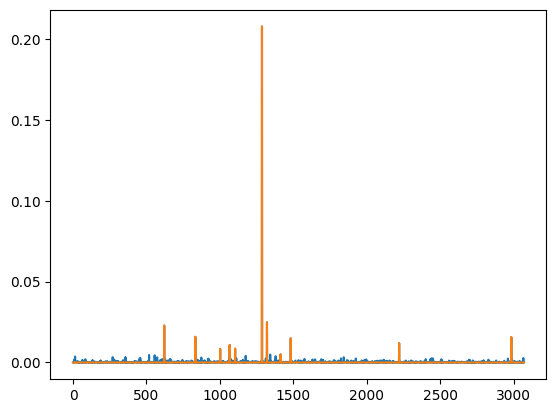

In [14]:
# Check how "sparse" the graph is
import matplotlib.pyplot as plt

# 10 has **a bunch** of connections
# feature = 10

feature = 9

max_features = np.argsort(graphCutoff[feature])[::-1]
# print(max_features[:10].tolist(), graphCutoff[feature][max_features][:10].tolist())
print(f"Feature has {graphCutoff[feature].nonzero()[0].shape[-1]} connections")

# print(graph[feature], dict_activations_prior.sum())
plt.plot(graph[feature])
plt.plot(graphCutoff[feature])

In [15]:
for i in range(num_features_main):
	if graphCutoff[i].sum() == 0:
		if graph[i].sum() > 0:
			print(f"Feature {i} has no connections in cutoff but {graph[i].sum()} connections in non-cutoff")
		else:
			print(f"Feature {i} has no connections at all!")

Feature 125 has no connections at all!
Feature 1270 has no connections at all!
Feature 2498 has no connections at all!


## Some Graphing

In [16]:
INCLUDE_WEIGHTS = True
PRIOR_ON_RIGHT = False
GRAPH_SIZE_MAIN = 10
D_NEIGHBORS = 20

In [17]:
main_feats = np.random.choice(num_features_main, GRAPH_SIZE_MAIN, replace=False)

[2346    5  847  218 2685  285 1879  999 2830 2215]


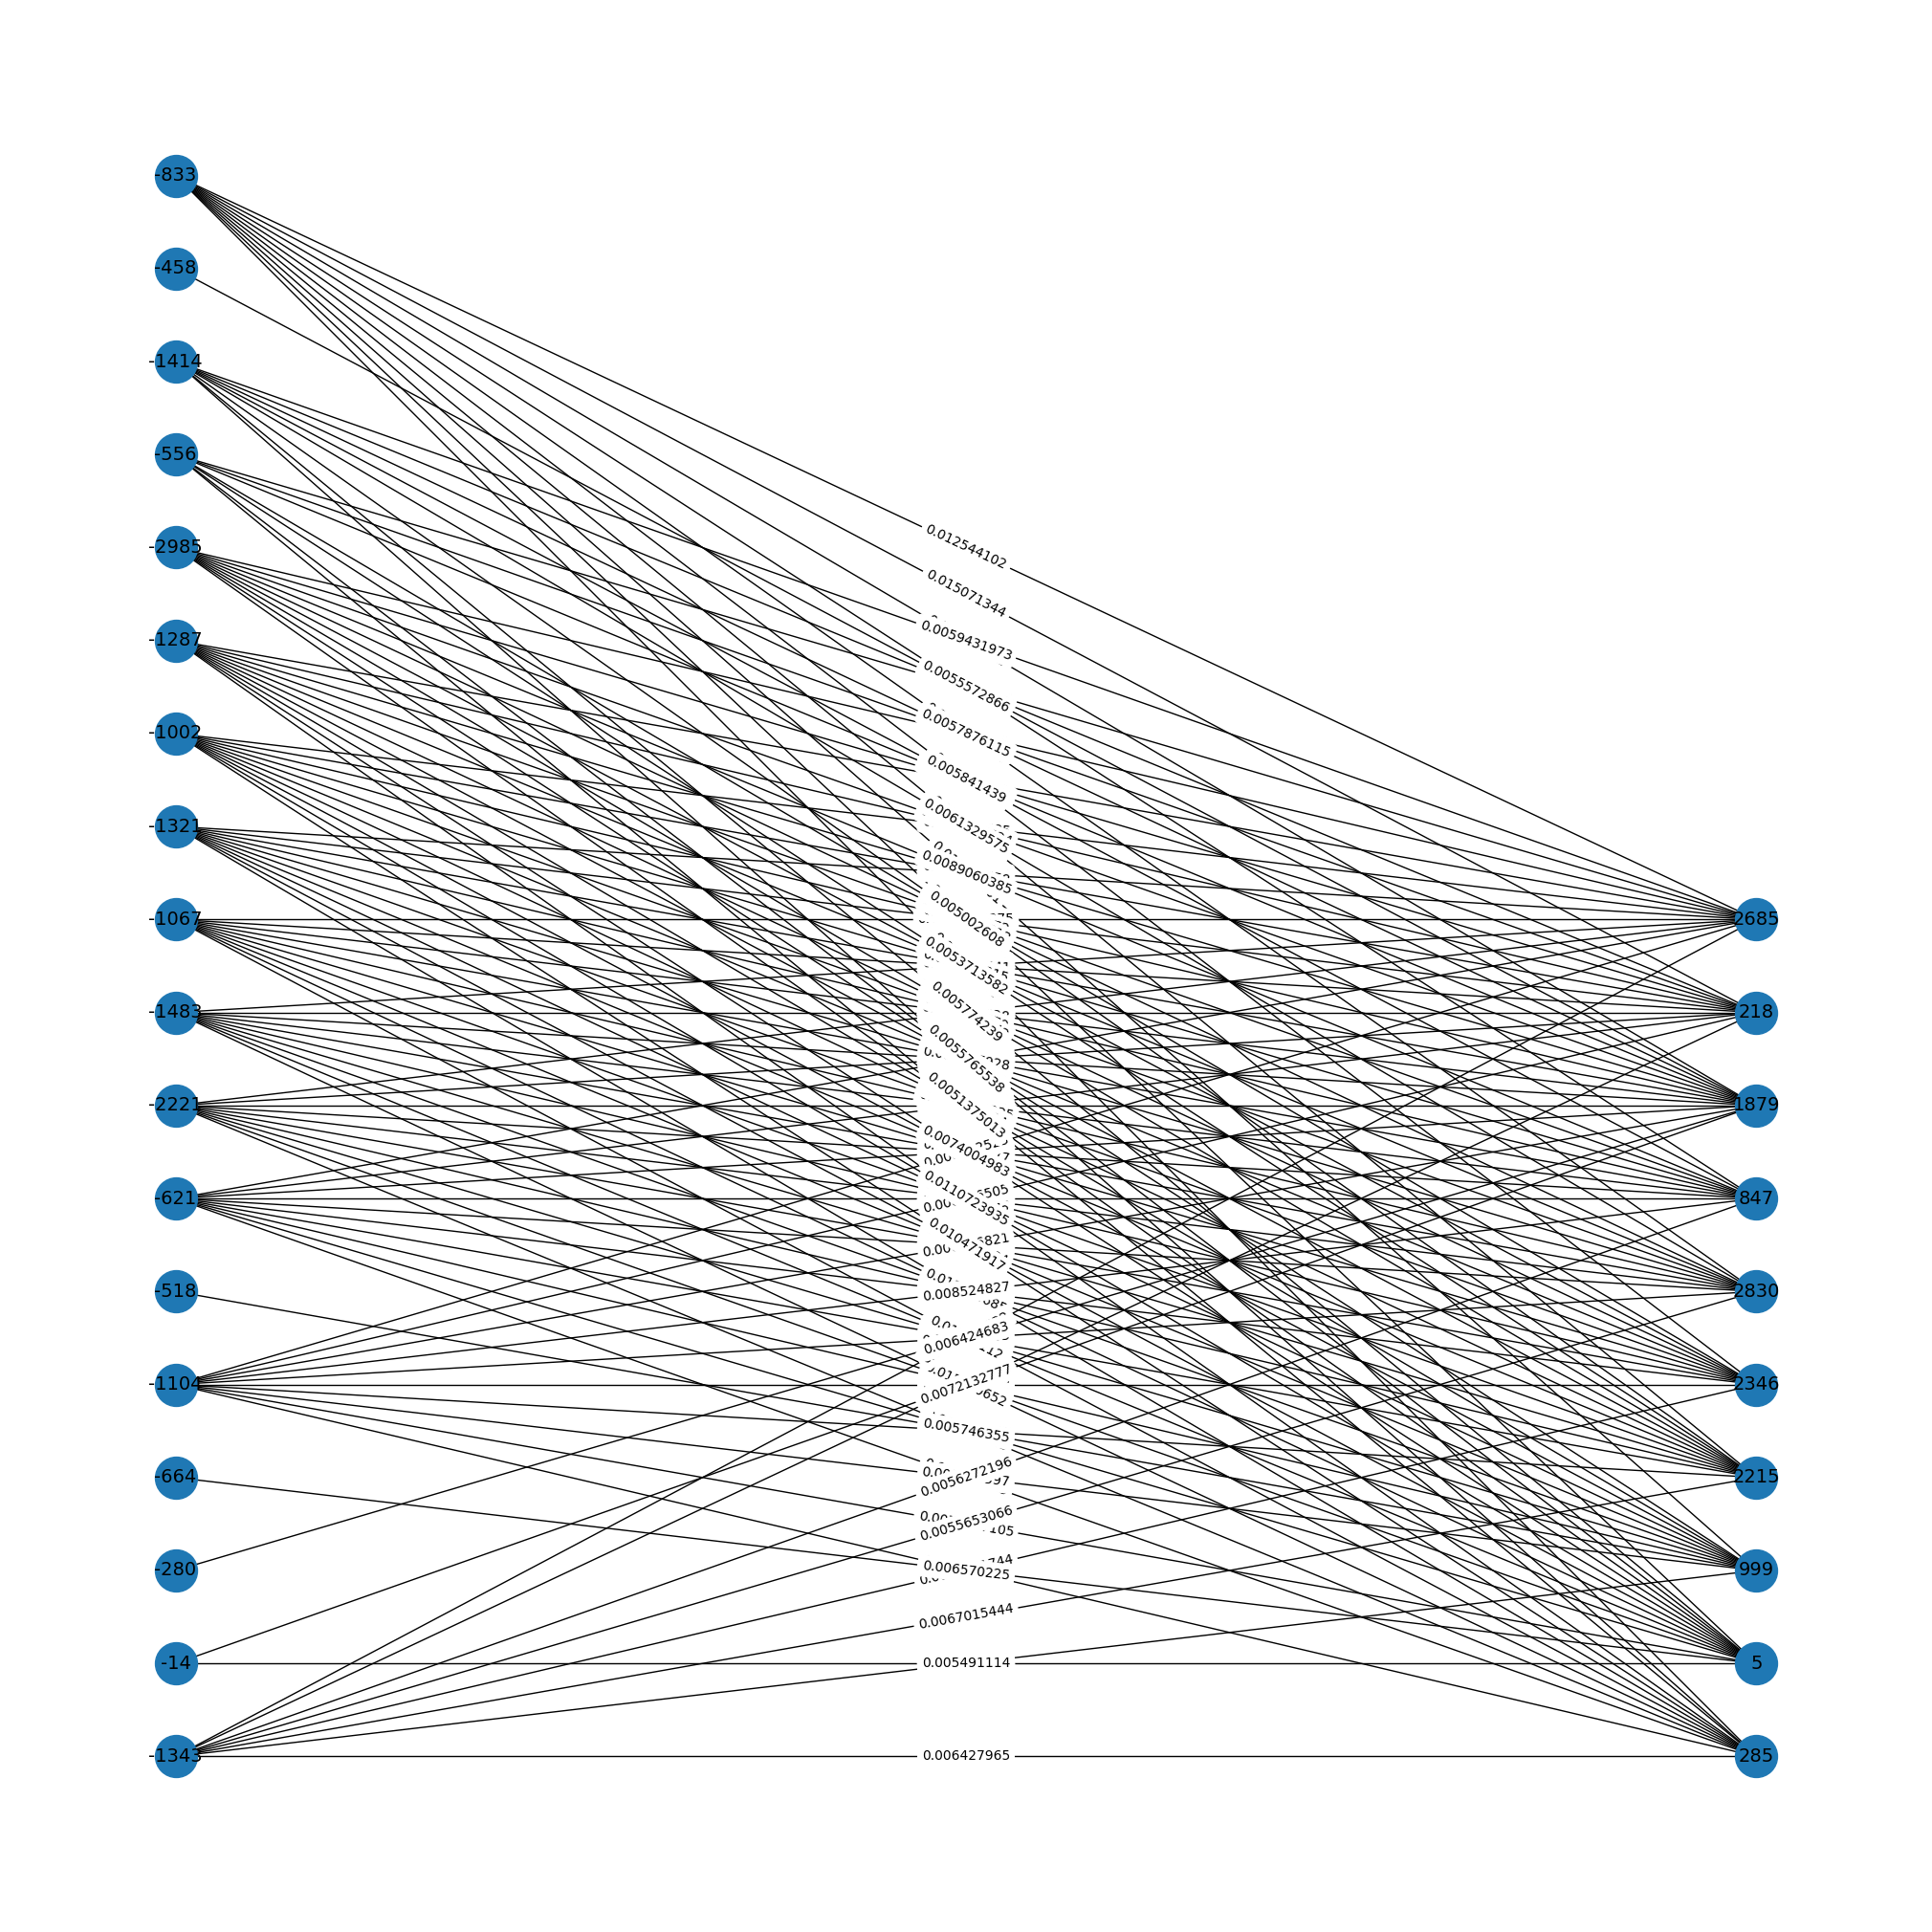

In [18]:
import matplotlib.pyplot as plt
import networkx as nx

# main_feats = np.random.choice(np.nonzero(graphCutoff.sum(axis=1))[0], GRAPH_SIZE_MAIN, replace=False)
print(main_feats)
prior_feats = np.nonzero(graphCutoff[main_feats])[1]

randomGraphProjection = graphCutoff[main_feats][:,prior_feats]


# Create a new bipartite graph
B = nx.Graph()

# Add nodes with the node attribute "bipartite"
# nodes_u = set((prior_feats * -1).tolist())  # Set of nodes V
# nodes_v = main_feats.tolist() # Set of nodes U
# B.add_nodes_from(nodes_u, bipartite=0)  # Label one set of nodes 0
# B.add_nodes_from(nodes_v, bipartite=1)  # Label the other set of nodes 1

edges = []

for main in main_feats:
	has_edge = False
	# nonzerod = graphCutoff[main].nonzero()[0]
	args = np.argsort(graphCutoff[main])[::-1][:D_NEIGHBORS]
	# print(args, graphCutoff[main][args])
	for prior in args:
		if graphCutoff[main][prior] > 0:
			if INCLUDE_WEIGHTS:
				edges.append((prior * -1, main, graphCutoff[main][prior]))
			else:
				edges.append((prior * -1, main))
			has_edge = True
	# for j in range(prior_feats.shape[-1]):
	# 	if randomGraphProjection[i,j] > 0:
	# 		print("Adding edge")
	# 		edges.append((prior_feats[j], main_feats[i], randomGraphProjection[i,j]))
	# 		has_edge = True
	if not has_edge:
		print("NO EDGE FOR FEATURE", main)
# Add edges with weights
if INCLUDE_WEIGHTS:
	B.add_weighted_edges_from(edges)
else:
	B.add_edges_from(edges)

# Separate by group
l, r = nx.bipartite.sets(B)

if PRIOR_ON_RIGHT:
	# Reverse the sets so that the LHS is the prior
	l, r = r, l
pos = {}

# Update position for node from each group
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))

# Draw the graph
plt.figure(1, figsize=(20, 20))
nx.draw(B, pos, with_labels=True, node_size=1_000, font_size=14)

# Draw edge labels
edge_labels = nx.get_edge_attributes(B, 'weight')

if INCLUDE_WEIGHTS:
	nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels)
else:
	pass
plt.show()

## Utils

In [19]:
from interp_utils import *
from circuitsvis.activations import text_neuron_activations
import torch
import numpy as np
from einops import rearrange

# Get the activations for the best dict features
def get_feature_datapoints_with_idx(feature_index, dictionary_activations, tokenizer, token_amount, dataset, k=10, setting="max"):
    best_feature_activations = dictionary_activations[:, :, feature_index].flatten()
    # Sort the features by activation, get the indices
    if setting=="max":
        found_indices = np.argsort(best_feature_activations)[:k]
        # found_indices = np.argsort(best_feature_activations, descending=True)[:k]
    elif setting=="uniform":
        # min_value = torch.min(best_feature_activations)
        min_value = np.min(best_feature_activations)
        max_value = np.max(best_feature_activations)

        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = np.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        # TODO: hmm
        # np bucketize?
        # bins = torch.bucketize(best_feature_activations, bin_boundaries)
        bins = np.digitize(best_feature_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in np.unique(bins):
            if(bin_idx==0): # Skip the first one. This is below the median
                continue
            # Get the indices corresponding to the current bin
            bin_indices = np.array(np.nonzero(bins == bin_idx)).squeeze(axis=0)
            # print(bin_indices.shape)
            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        found_indices = np.flip(np.array(sampled_indices), axis=[0])
    else: # random
        # get nonzero indices
        nonzero_indices = torch.nonzero(best_feature_activations)[:, 0]
        # shuffle
        shuffled_indices = nonzero_indices[torch.randperm(nonzero_indices.shape[0])]
        found_indices = shuffled_indices[:k]
    num_datapoints = int(dictionary_activations.shape[0])
    datapoint_indices =[np.unravel_index(i, (num_datapoints, token_amount)) for i in found_indices]
    text_list = []
    full_text = []
    token_list = []
    full_token_list = []
    for md, s_ind in datapoint_indices:
        md = int(md)
        s_ind = int(s_ind)
        full_tok = torch.tensor(dataset[md]["input_ids"])
        full_text.append(tokenizer.decode(full_tok))
        tok = dataset[md]["input_ids"][:s_ind+1]
        text = tokenizer.decode(tok)
        text_list.append(text)
        token_list.append(tok)
        full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list, found_indices

## Some interpretability with GPT-4 and **context**

In [20]:
from interp_utils import get_neuron_activation

def get_activations_for_text(feature_idx : int, t : str):
	split_text = model.to_str_tokens(t, prepend_bos=False)
	token = model.to_tokens(t, prepend_bos=False)
	_a = get_neuron_activation(token, feature_idx, model, autoencoder_prior, layer_focus - 1, setting="dictionary_basis")
	return _a

print(get_activations_for_text(1321, "1 + 1"))

2023-11-07 14:27:44.899691: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-07 14:27:45.037324: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 14:27:45.588430: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[0.0, 0.0, 0.0]


In [21]:
# From https://github.com/openai/automated-interpretability/blob/main/neuron-explainer/neuron_explainer/explanations/explainer.py


ROLE_NO_PRIOR = "We're studying neurons in a neural network. Each neuron looks for some particular" + \
"thing in a short document. Look at the parts of the document the neuron activates for " + \
"and summarize in a single sentence what the neuron is looking for. Don't list " + \
"examples of words.\n\nThe activation format is token<tab>activation. Activation " + \
"values range from 0 to 10. A neuron finding what it's looking for is represented by a " + \
"non-zero activation value. The higher the activation value, the stronger the match. Only respond with what the neuron does."
 

ROLE_YES_PRIOR = "We're studying neurons in a neural network. Each neuron looks for some particular" + \
"thing in a short document. Look at the parts of the document the neuron activates for " + \
"and summarize in a single sentence what the neuron is looking for. We will also give neural concepts which are upstream of what the current neuron is looking for. The upstream concepts should play a role in what the current neuron is looking for. " +\
"Don't list " + \
"examples of words.\n\nThe activation format is token<tab>activation. Activation " + \
"values range from 0 to 10. A neuron finding what it's looking for is represented by a " + \
"non-zero activation value. The higher the activation value, the stronger the match. Only respond with what the neuron does."
 


def get_samples_and_act_for_feature(feature_idx: int, autoencoder, layer: int, dict_activations, n_samples=10):
	text_list, _, _, _, _ = get_feature_datapoints_with_idx(feature_idx, dict_activations, model.tokenizer, token_amount, dataset, setting="uniform", k=n_samples)
	split_texts = []
	activations = []
	max_act = -1
	min_act = 1e10
	for t in text_list:
		split_text = model.to_str_tokens(t, prepend_bos=False)
		token = model.to_tokens(t, prepend_bos=False)
		_a = get_neuron_activation(token, feature_idx, model, autoencoder, layer, setting="dictionary_basis")
		acts = np.array(_a)
		if acts.sum() > 0:
			# Rescale to between 0 and 10
			# activations.append((acts - acts.min()) / ((acts.max() - acts.min()) / 10))
			if acts.max() > max_act:
				max_act = acts.max()
			if acts.min() < min_act:
				min_act = acts.min()

			activations.append(acts)
			split_texts.append(split_text)
	
	for i in range(len(activations)):
		activations[i] = (activations[i] - min_act) / ((max_act - min_act) / 10)
		activations[i] = activations[i].tolist()
	return split_texts, activations



# TODO: integrate with auto-inter?
def create_prompt(feature_idx: int, autoencoder, layer, dict, n_samples=10, prior_feature_description=None):
	# TODO: Adjust k!!
	texts, acts = get_samples_and_act_for_feature(feature_idx, autoencoder=autoencoder,
																							 layer=layer, dict_activations=dict, n_samples=n_samples)	
	entries = []
	for t, a in zip(texts, acts):
		e = []
		# print("TEXT:", t)
		# print("ACTIVATION:", a)
		for tok, act in zip(t, a):
			e.append(f"{tok}\t{act}")
		joined = '\n'.join(e)
		entries.append(f"<start>\n{joined}\n<end>")
	joined = "\n".join(entries)
	if prior_feature_description is not None:
		upstream_concepts = "\n\n".join(prior_feature_description)
		return f"""{ROLE_YES_PRIOR}

Neuron {feature_idx}
Activations:
{joined}


Upstream Neuron Concepts:
{upstream_concepts}
"""
	else:
		return f"""{ROLE_NO_PRIOR}

Neuron {feature_idx}
Activations:
{joined}

"""

In [22]:
from dotenv import load_dotenv
load_dotenv()

True

In [23]:
from langchain.chat_models import ChatOpenAI

# Cool we found a hard-to-understand feature
feature = 32
s = create_prompt(feature, autoencoder_main, layer_focus, dict_activations_main, n_samples=20)
llm = ChatOpenAI(model_name='gpt-4')
print(s), llm.invoke(input=s)

We're studying neurons in a neural network. Each neuron looks for some particularthing in a short document. Look at the parts of the document the neuron activates for and summarize in a single sentence what the neuron is looking for. Don't list examples of words.

The activation format is token<tab>activation. Activation values range from 0 to 10. A neuron finding what it's looking for is represented by a non-zero activation value. The higher the activation value, the stronger the match. Only respond with what the neuron does.

Neuron 32
Activations:
<start>
AP	0.0

	0.0

	0.0
Gi	0.0
ants	0.8088433959189275
 running	0.0
 back	0.0
 Rash	0.0
ad	0.0
 Jennings	0.0
 isn	0.0
’	0.0
t	0.0
 the	0.0
 only	0.0
 NFC	0.0
 East	0.0
 player	0.0
 talking	0.0
 Super	0.0
 Bowl	0.0
 in	0.0
 April	0.0
.	0.0

	0.0

	0.0
C	0.0
ow	10.0
<end>
<start>
Too	0.0
 late	0.0
 smart	0.0
:	0.0
 farmers	0.0
'	0.0
 adoption	0.0
 of	0.0
 self	0.0
-	0.0
protective	0.0
 behaviors	0.0
 in	0.0
 response	0.0
 to	0.0
 exposure

(None,
 AIMessage(content='The neuron is looking for words that end with a specific "ow" sound.', additional_kwargs={}, example=False))

In [36]:
F_T = 2830
text_list, full_text, token_list, full_token_list, sampled_indices = get_feature_datapoints_with_idx(F_T, dict_activations_main, model.tokenizer, token_amount, dataset, setting="uniform", k=10)
visualize_text(text_list, F_T, model, autoencoder_main, layer_focus)

## Try to use the concept lattice to inform the feature description

In [25]:
text_list, full_text, token_list, full_token_list, sampled_indices = get_feature_datapoints_with_idx(556, dict_activations_prior, model.tokenizer, token_amount, dataset, setting="uniform", k=10)
visualize_text(text_list, 556, model, autoencoder_prior, layer_focus - 1)

In [42]:
# Cool we found a hard-to-understand feature
# feature = 32

# Cool we found a hard-to-understand feature
feature = 2830

feature = 2685

def get_upstream_features(feature) -> list[int]:
	return graphCutoff[feature].nonzero()[0].tolist()
get_upstream_features(feature)

[556, 621, 833, 1002, 1067, 1104, 1287, 1321, 1343, 1414, 1483, 2221, 2985]

In [43]:

def get_descr_prior(feature) -> str:
	s = create_prompt(feature, autoencoder_prior, layer_focus - 1, dict_activations_prior, n_samples=20)
	llm = ChatOpenAI(model_name='gpt-4')
	c = llm.invoke(input=s).content
	print("upstream feature description:", c)
	return c

upstream_descr = [get_descr_prior(f) for f in get_upstream_features(feature)]

s = create_prompt(feature, autoencoder_main, layer_focus, dict_activations_main, n_samples=30, prior_feature_description=upstream_descr)
llm = ChatOpenAI(model_name='gpt-4')
print(s), llm.invoke(input=s)
# TODO: if no activations, resample or something.... (or lets sample larger idk)... need to figure out this uniform thing

upstream feature description: The document doesn't provide any activations for Neuron 556, so we cannot determine what this neuron is looking for.
upstream feature description: The neuron is looking for action or process related verbs in a document.
upstream feature description: Neuron 833 activates for introductory words and terms related to technology and media.
upstream feature description: The neuron is looking for parts of compound words or names.
upstream feature description: The neuron is looking for specific names and words, indicating it may be searching for proper nouns or unique identifiers.
upstream feature description: Neuron 1104 is looking for hyphen or ellipsis symbols in a document.
upstream feature description: The neuron is looking for medical, scientific, and academic terms and concepts.
upstream feature description: The neuron is looking for punctuation marks and short linking words or phrases.
upstream feature description: Neuron 1343 activates for specific terms 

(None,
 AIMessage(content='This neuron is looking for terms related to the digestive system, particularly the intestines and the gut, possibly in a medical or scientific context.', additional_kwargs={}, example=False))

In [41]:
# Without priors

feature = 2685
s = create_prompt(feature, autoencoder_main, layer_focus, dict_activations_main, n_samples=30, prior_feature_description=None)
llm = ChatOpenAI(model_name='gpt-4')
print(s), llm.invoke(input=s)

We're studying neurons in a neural network. Each neuron looks for some particularthing in a short document. Look at the parts of the document the neuron activates for and summarize in a single sentence what the neuron is looking for. Don't list examples of words.

The activation format is token<tab>activation. Activation values range from 0 to 10. A neuron finding what it's looking for is represented by a non-zero activation value. The higher the activation value, the stronger the match. Only respond with what the neuron does.

Neuron 2685
Activations:
<start>
Many	0.0
 pathogens	0.09135212055491813
 use	0.0
 the	0.0
 intestinal	10.0
<end>
<start>
Clinical	0.0
 significance	0.0
 of	0.0
 intestinal	9.80657089030138
<end>
<start>
The	0.0
 gastrointestinal	9.500143876885318
<end>
<start>
[	0.0
In	0.0
n	0.0
ovation	0.0
 in	0.0
 the	0.0
 incorporation	0.0
 of	0.0
 mac	0.0
ron	0.0
ut	0.0
rients	0.0
 to	0.0
 ent	0.0
eral	0.0
 nutrition	1.092418200682262
 formulas	0.0
].	0.0

	0.0
Enter	0.4454

(None,
 AIMessage(content='The neuron is looking for references to parts of the digestive system, particularly the intestines and related processes such as nutrition and metabolism.', additional_kwargs={}, example=False))

# Feature Interp
Investigate the example sentences the activate this feature.

Max: show max activating (tokens,contexts)

Uniform: Show range of activations from each bin (e.g. sample an example from 1-2, 2-3, etc). 
[Note: if a feature is monosemantic, then the full range of activations should be that feature, not just max-activating ones]

Full_text: shows the full text example

Text_list: shows up to the most activating example (try w/ max activating on a couple of examples to see)

ablate_text: remove the context one token at a time, and show the decrease/increase in activation of that feature

ablate_feature_direction: removes feature direction from model's activation mid-inference, showing the logit diff in the output for every token.

logit_lens: show the logit lens for that feature. If matches ablate_feature_direction, then the computation path is through the residual stream, else, it's through future layers

In [28]:
dict_activations_prior.shape

(9862, 40, 3072)

In [29]:
feature_idx = 20
text_list, full_text, token_list, full_token_list, sampled_indices = get_feature_datapoints_with_idx(feature_idx, dict_activations_prior, model.tokenizer, token_amount, dataset, setting="uniform", k=100)
visualize_text(text_list, feature_idx, model, autoencoder_prior, layer_focus - 1)

In [30]:
feature_idx = 2447

text_list, full_text, token_list, full_token_list, sampled_indices = get_feature_datapoints_with_idx(feature_idx, dict_activations_main, model.tokenizer, token_amount, dataset, setting="uniform", k=100)
visualize_text(text_list, feature_idx, model, autoencoder_prior, layer_focus)